In [1]:
!pip install qiskit-algorithms
from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, state_fidelity, partial_trace
from scipy.linalg import expm
import matplotlib.pyplot as plt
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.visualization import array_to_latex
 
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

# 2-D XY Model Hamiltonian
$H_{XY} = \sum_{<i,j>}g_{ij}(X_iX_j + Y_iY_j)/2 + \sum_ij_iZ_i$

A 4-qubit $2\times2$ lattice with nearest-neighbor connections ($g_{ij}$) and on-site potentials ($j_i$) is used in this example. The below cell can be converted into a function to generate arbitrary XY-Hamiltonians.

In [43]:
# create H
from qiskit.quantum_info import SparsePauliOp
# Define Pauli terms
pauli_strings = [
    "XXII", "XIXI", "IXIX", "IIXX",  # X interactions
    "YYII", "YIYI", "IYIY", "IIYY",  # Y interactions
    "ZIII", "IZII", "IIZI", "IIIZ"   # Z terms
]

# Define corresponding coefficients: Coefficients are chosen s.t. there is a significant gap
# between the ground state energy and the first excited state energy

# 1. Coupling terms
G = 0.5
# Z terms
J = 8
coefficients = [G/2] * 8 + [J] * 4  # 0.5 for XX, YY terms, 1.0 for Z terms

# Create the SparsePauliOp Hamiltonian
H = SparsePauliOp(pauli_strings, coefficients)

# Print the Hamiltonian
# print(H.to_matrix().real)

# calculate the number of qubits
n_qubits = int(np.sqrt(len(H.to_matrix().real)))
print(f"# qubits in the lattice: {n_qubits}")

# qubits in the lattice: 4


## Shift and Rescale H
The original $H_{XY}$ needs to be shifted such that its eigenvalues ($\lambda_i$) $\in (\eta, \pi - \eta)$

This is done to ensure that $cos(\frac{\lambda_i}{2})$ $\in (0,1)$ to ease the filter design.

In [57]:
# shift and rescale the H
E, V = np.linalg.eig(H.to_matrix().real)

delta = (np.max(E)-np.min(E))
Emin = np.min(E)
eta = 0.1
print(f"eta: {eta}")


c1 = (np.pi-2*eta)/delta
c2 = eta-Emin*c1

# Create the n x n identity matrix
In = np.eye(2**n_qubits)

# shift and rescale the H
H_sim = c1*H.to_matrix().real + c2*In

# print the shifted eigenvals
E_sim = np.linalg.eig(H_sim)[0]
print(f"Max shifted E: {np.max(E_sim)}")
print(f"Min shifted E: {np.min(E_sim)}")

eta: 0.1
Max shifted E: 3.041592653589793
Min shifted E: 0.10000000000000009


## Controlled Pauli Strings for c-U 

A "chessboard patterned" Pauli string would follow the anti-commutation condition. Black squares are $\hat{X}$, and white squares are $\hat{Y}$.
Switching $\hat{X}$ with $\hat{Y}$ should also do.

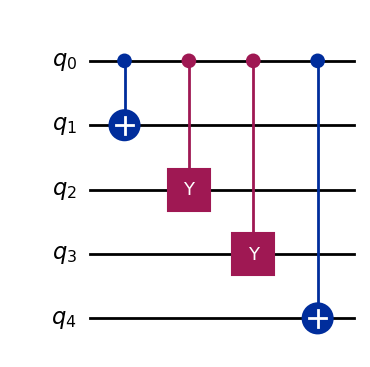

In [60]:
# Create Pauli Strings
n_sim_qubits = n_qubits+1
def cPauli(num_qubits):
    # create a quantum circuit
    qc_cK = QuantumCircuit(num_qubits, name="cK")
    # for qubit index (i,j), cx, if i+j is odd, else cy
    lattice_size = int(np.sqrt(num_qubits-1))
    for qi in range(num_qubits-1):
        i = int(qi/lattice_size)
        j = qi%lattice_size
        flag = i+j
        if flag%2==0:
            qc_cK.cx(0,qi+1)
        else:
            qc_cK.cy(0,qi+1)

    return qc_cK

# Test the controlled-Pauli function 
ck = cPauli(n_sim_qubits)
ck.draw(output="mpl", fold =-1)

## Z-Rotations for shifting the Hamiltonian (Unitary)

Pauli strings anti-commute with H, but do not anti-commute with I:

$$K(c_1H + c_2I)K = c_1KHK + c_2KIK$$
$$= -c_1H + c_2$$

However, we need $-c_1H - c2I$ to generate $U^{\dagger}$. Therefore, we can't directly use $K H_{mod} K$ to create time-reversal. $U^{\dagger}$ can be written as:
$$\ket{0}\bra{0} \otimes e^{(i\frac{c_1H}{2} + i\frac{c_2I}{2})} + \ket{1}\bra{1} \otimes e^{(-i\frac{c_1H}{2} - i\frac{c_2I}{2})}$$
$$= (\ket{0}\bra{0} \otimes e^{i\frac{c_1H}{2}} + \ket{1}\bra{1} \otimes e^{-i\frac{c_1H}{2}})(\ket{0}\bra{0} \otimes e^{+i\frac{c_2I}{2}} + \ket{1}\bra{1} \otimes e^{-i\frac{c_2I}{2}})$$
$$= (\ket{0}\bra{0} \otimes e^{ic_1H/2} + \ket{1}\bra{1} \otimes e^{-ic_1H/2})e^{-i\frac{c_2}{2}\hat{Z}}$$

Therefore, the shift in $H$ can be enabled in the corresponding unitary by using a $Z$-rotation. 

We use the followinf relations to create $cU$ and $cU^{\dagger}$ using $cK$:
$$cU^{\dagger} = cKUcK$$
$$\hat{X}cU^{\dagger}\hat{X} = cU$$

In [81]:
# Create the U with c1*H and add an extra Z-rotation to shift c1*H by c2 
from qiskit.circuit.library import UnitaryGate

# Scale the original H matrix
H_scaled = c1*H.to_matrix()

# Create the corresponding Unitary Gate U(c1/2)
U_scaled = expm(-1.j*H_scaled/2)
Uc1_g = UnitaryGate(U_scaled, label="U(c1/2)")

In [83]:
# load the phases and convert them to X-rotations 
phases_su2 = np.loadtxt("phases_10_new.txt")
phases  = phases_su2 + np.pi/2
phases[0] = phases[0] - np.pi/4
phases[-1] = phases[-1] - np.pi/4

# print(phases-phases_su2)

### Create the QETU Circuit

In [86]:
# create the initial state

qc = QuantumCircuit(n_sim_qubits)

# apply the hadamard gate to prepare and equiprobable state (in the H subspace only)
for qi in range(1,n_sim_qubits):
    qc.h(qi)

state_init = Statevector.from_instruction(qc)
state_init.draw('latex')

<IPython.core.display.Latex object>

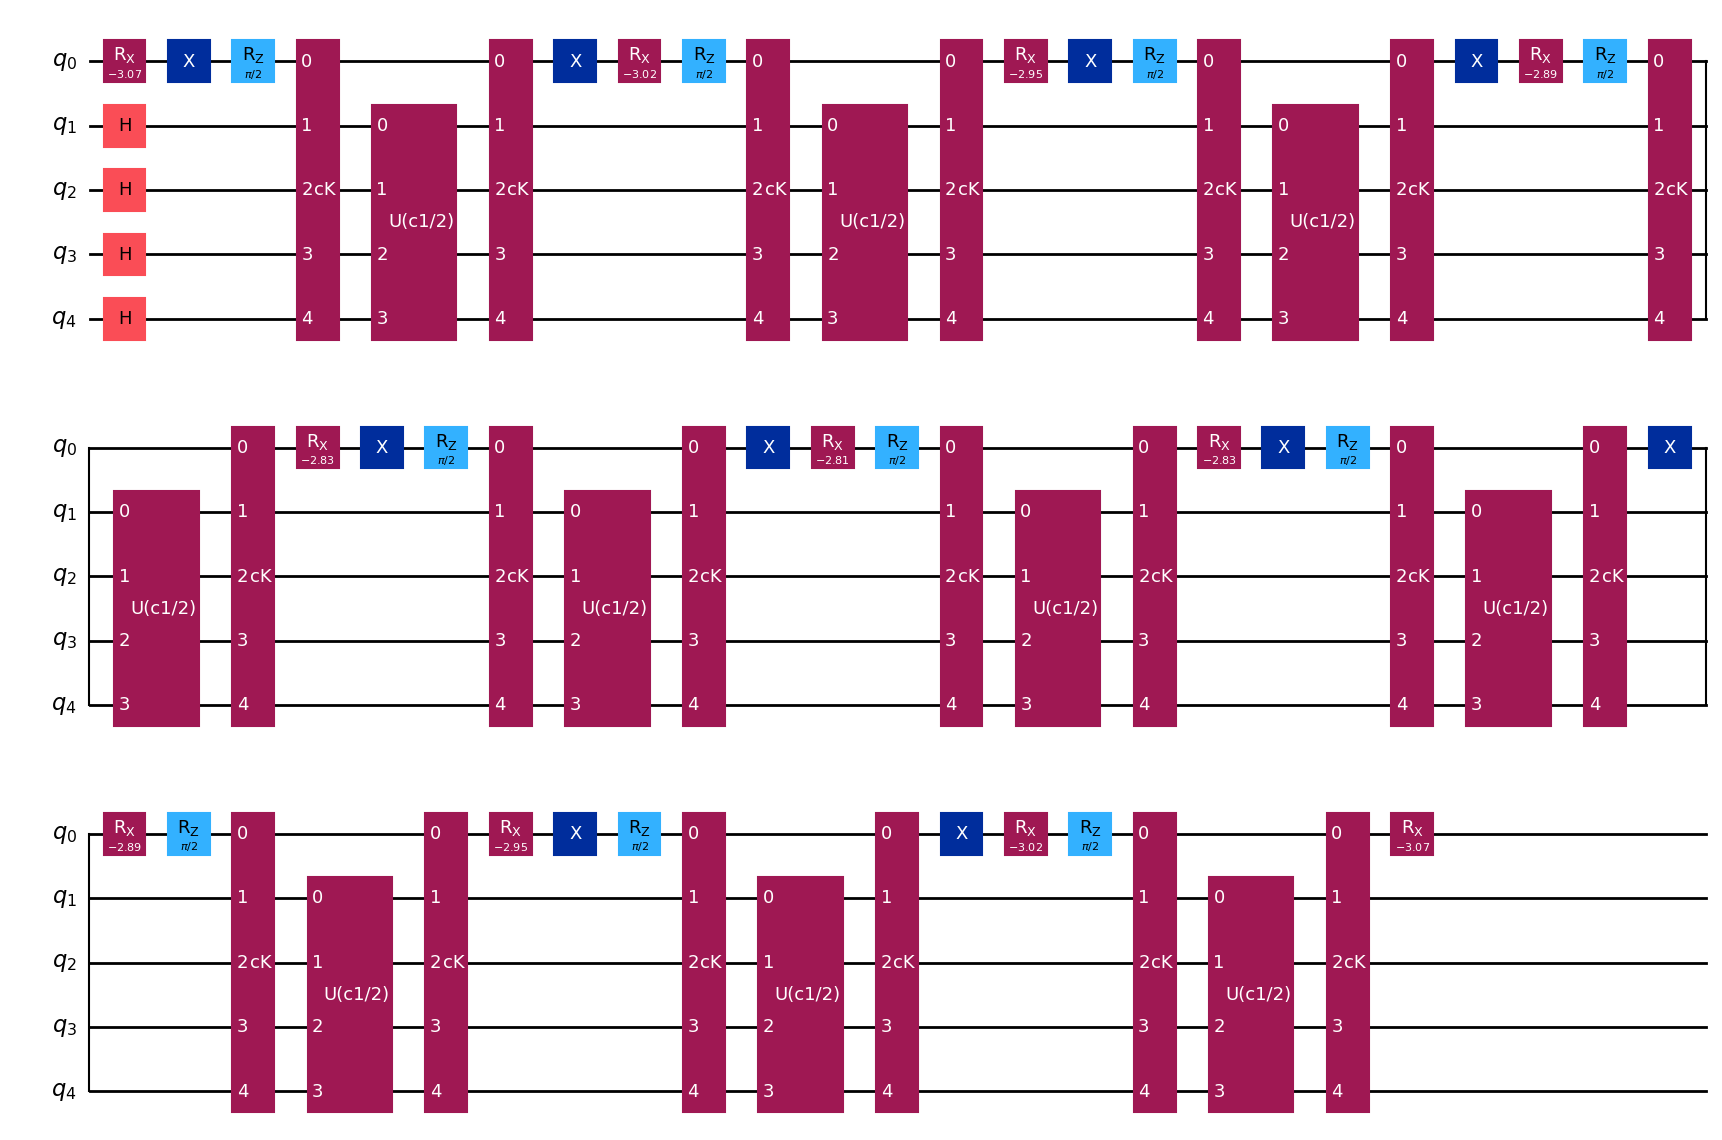

In [88]:
# create the QETU circuit
stage = 0
for p in phases:
    qc.rx(-2*p,0)
    stage += 1
    if stage != len(phases):
        if stage%2 == 1:
            # Apply cU:
            # 1. flip the ancilla
            qc.x(0)
            # 2. Z-rotation to shift c1*H
            qc.rz(c2,0)
            # 3. cK U(c1/2) cK = cU_dagger(c1/2)
            qc.append(cPauli(n_sim_qubits), range(n_sim_qubits))
            qc.append(Uc1_g, range(1,n_sim_qubits))
            qc.append(cPauli(n_sim_qubits), range(n_sim_qubits))
            # 4. flip the ancilla back
            qc.x(0)
        else:
            # Apply cU_dagger:
            # 1. Z-rotation to shift c1*H
            qc.rz(c2,0)
            # 2. cK U(c1/2) cK = cU_dagger(c1/2)
            qc.append(cPauli(n_sim_qubits), range(n_sim_qubits))
            qc.append(Uc1_g, range(1,n_sim_qubits))
            qc.append(cPauli(n_sim_qubits),range(n_sim_qubits))

qc.draw('mpl')

In [33]:
state = Statevector.from_instruction(qc)
substate_data = state.data[0::2]

# Create a new Statevector object from the extracted amplitudes
substate = Statevector(substate_data)

# Normalize the substate (to emulate a '0' measurement on the ancilla)
norm_substate = Statevector(substate / np.linalg.norm(substate))

# print(norm_substate)
norm_substate.draw('latex')

<IPython.core.display.Latex object>

In [90]:
# Calculate the overlap and fidelity
target = Statevector.from_label('1111')

# Calculate the overlap
overlap = norm_substate.inner(target).real
fidelity = (abs(overlap))**2
print(overlap)
print(fidelity)

-0.9977226482969603
0.9954504829247
